In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

306/306 [==============================] - 0s 732us/step
              precision    recall  f1-score   support

           0       0.14      0.33      0.19      1233
           1       0.88      0.70      0.78      8536

    accuracy                           0.66      9769
   macro avg       0.51      0.52      0.49      9769
weighted avg       0.79      0.66      0.71      9769

Precision: 0.13804828289697382
Recall: 0.32927818329278186
F1 Score: 0.1945376137997125


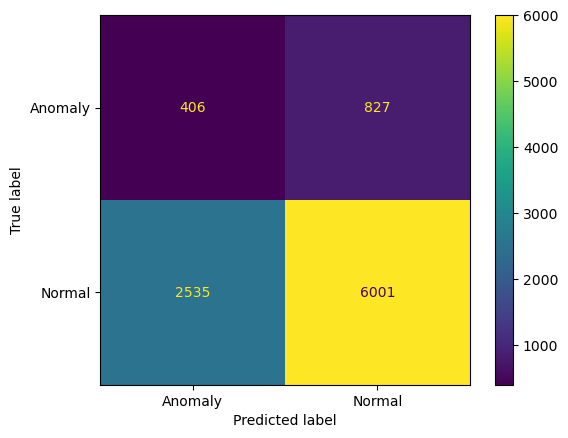

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report, confusion_matrix

def complete_anomaly_detection_system():
    # Load data from a CSV file
#     def load_data(filepath):
#         data = pd.read_csv(filepath)
#         X = data.drop('target', axis=1).values  # adjust 'target' if your column name is different
#         y = data['target'].values
#         return X, y
    
    
    
    data = pd.read_csv('adultdata.csv')
    
    #convert all the values in the columns into numeric
    label_encoder = LabelEncoder()
    for column in data.select_dtypes(include=['object']).columns:
        data[column] = label_encoder.fit_transform(data[column])
    
    data = data.drop('Sex', axis=1)
    
    X = data.drop('fnlwgt', axis=1)  # Assuming 'target' is the column name of the continuous target variable
    y_cont = data['fnlwgt']
    
    y = np.where(y_cont > 80000, 1, 0)  # Define `threshold` based on your domain knowledge
    
    # Select top k features; k might be adjusted based on the dataset
    selector = SelectKBest(f_classif, k=10)
    X_selected = selector.fit_transform(X, y)
    
    #data.info()


    data.dropna(axis=0, inplace=True)
    
    
    

    # Build a sparse autoencoder
    def build_autoencoder(input_dim, encoding_dim):
        input_layer = tf.keras.Input(shape=(input_dim,))
        encoded = layers.Dense(encoding_dim, activation='relu', 
                               activity_regularizer=regularizers.l1(10e-5))(input_layer)
        decoded = layers.Dense(input_dim, activation='sigmoid')(encoded)
        autoencoder = models.Model(input_layer, decoded)
        encoder = models.Model(input_layer, encoded)
        autoencoder.compile(optimizer='adam', loss='mean_squared_error')
        return autoencoder, encoder

    #X_selected, y = load_data(filepath)
    
    # Scale the features to [0, 1]
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X_selected)
    
    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
    
    
    # Train the autoencoder
    autoencoder, encoder = build_autoencoder(X_train.shape[1], 32)
    autoencoder.fit(X_train, X_train, epochs=50, batch_size=256, shuffle=True, validation_split=0.1, verbose=0)
    
    # Encode the data
    X_train_encoded = encoder.predict(X_train)
    X_test_encoded = encoder.predict(X_test)
    
    # Train SVM on the encoded data
    svm = SVC(kernel='rbf', gamma='auto', class_weight='balanced', random_state=42)
    svm.fit(X_train_encoded, y_train)
    
    # Predict with SVM
    svm_predictions_train = svm.predict(X_train_encoded)
    
    # Filter only rows SVM detected as normal
    normal_indices_train = svm_predictions_train == 1
    X_train_normal = X_train_encoded[normal_indices_train]
    
    # Train Isolation Forest on the filtered normal data
    iso_forest = IsolationForest(random_state=42)
    iso_forest.fit(X_train_normal)
    
    # Predict on the test data with Isolation Forest
    if_predictions = iso_forest.predict(X_test_encoded)
    if_predictions = np.where(if_predictions == 1, 1, 0)  # Convert -1, 1 to 0, 1
    
    # Evaluate the model
    precision = precision_score(y_test, if_predictions, pos_label=0)
    recall = recall_score(y_test, if_predictions, pos_label=0)
    f1 = f1_score(y_test, if_predictions, pos_label=0)
    
    print(classification_report(y_test, if_predictions))
    

    # Print metrics
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")

    # Display the confusion matrix
    cm = confusion_matrix(y_test, if_predictions, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Anomaly', 'Normal'])
    disp.plot()
    plt.show()

# Example usage
complete_anomaly_detection_system()
